In [1]:
%matplotlib inline

import dlc_practical_prologue as prologue
import torch.nn as nn
import torch

import matplotlib.pyplot as plt
import random
from models import FNN, FNN_WS, FNN_WS_AUX, FNN_AUX, CNN, CNN_WS_AUX, CNN_WS, CNN_AUX

In [2]:
# Load the data
size = 1000
train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(size)


#normalization
#check https://stats.stackexchange.com/questions/174823/
mu, std = train_input.mean(), train_input.std()
train_input, test_input = train_input.sub(mu).div(std), test_input.sub(mu).div(std)

#split the images
train_input1, train_input2 = train_input[:, 0, :, :], train_input[:, 1, :, :] 
test_input1, test_input2 = test_input[:, 0, :, :], test_input[:, 1, :, :] 

#split the number pairs
train_classes1, train_classes2 = train_classes[:, 0], train_classes[:, 1]
test_classes1, test_classes2 = test_classes[:, 0], test_classes[:, 1]

In [3]:
"""
:param model: a dict encapsulating the model and its properties
:param inps1: lhs of image pairs
:param inps2: rhs of image pairs
:param digits1: classes of inps1 
:param digits2: classes of inps2
:param targets: final boolean value indicating whether lhs <= rhs
:return: a dict encapsulating the model history
"""
def train_model(model, inps1, inps2, digits1, digits2, targets):
    
    epochs = model['nb_epochs']
    batch_size = model['batch_size']
    criterion = model['criterion']
    optimizer = model['optimizer']
    mdl = model['model']
      
    #  a dict to return whatever value we wanna return
    #  e.g. loss at each epoch (useful for plotting)
    model_history = dict()
    
    
    loss_history = [] #a list to keep track of the losses at each epoch
    for e in range(epochs):
        train_indices = random.sample(range(inps1.size(0)), batch_size)  # pick a minibatch   
        d1, d2, pred = mdl(inps1[train_indices], inps2[train_indices])   # run through the network
        pred_loss =  criterion(pred.view(-1, 2), targets[train_indices]) # loss due to boolean value
            
        #this is where auxillary loss happens depending on the model.
        #if a model returns the digit information, it is taken into account in the backprop.
        #if there is no digit info only loss we have is the one due to boolean above
        if d1 is not None:
            pred_loss += criterion(d1.view(-1, 10), digits1[train_indices])
            pred_loss += criterion(d2.view(-1, 10), digits2[train_indices])
            pred_loss /= 3
            
        loss = pred_loss.item() #magnitude of the loss
        mdl.zero_grad()         #reset the gradients for this epoch
        pred_loss.backward()    #calculate the gradients
        optimizer.step()        #update the weights
            

        loss_history.append(loss) #record the loss 
        
    model_history['loss_history'] = loss_history
    return model_history

In [4]:
"""
:param model: a dict encapsulating the model and its properties
:param inps1: lhs of image pairs
:param inps2: rhs of image pairs
:param digits1: classes of inps1 
:param digits2: classes of inps2
:param targets: final boolean value indicating whether lhs <= rhs
:return: a triplet indicating the accuracies ordered as (boolean,lhs,rhs)
"""
def compute_nb_errors(model, inps1, inps2, digits1, digits2, targets):
    n_samples = inps1.shape[0]
    
    d1,d2,pred = model(inps1, inps2)           # predict the digits + boolean
    _, indices = torch.max(pred.view(-1,2), 1) # torch.max returns the max value from the distribution and its corresponding index
    acc_target = (sum(indices == targets) / float(n_samples) * 100).item()  #calculate accuracy

    acc_d1, acc_d2 = 0, 0
    if d1 is not None: #the model returns digits if it makes use of aux loss. in this case we can report the accuracy of predicting the digits.
        _, indices1 = torch.max(d1.view(-1,10), 1)
        _, indices2 = torch.max(d2.view(-1,10), 1)
        acc_d1 += (sum(indices1 == digits1) / float(n_samples) * 100).item()
        acc_d2 += (sum(indices2 == digits2) / float(n_samples) * 100).item()
    
    
    return (acc_target, acc_d1, acc_d2)

  

In [5]:
"""
:param model_constructor: constructor for the model
:param optimizer_name: 'sgd' or 'adam'
:param lr: learning rate
:param batch_size: batch_size.
:return: an encapsulated model ready for the training
"""
def model_selector(model_constructor, optimizer_name, lr, batch_size):
    model = dict()
    model['model'] = model_constructor()
    model['criterion'] = nn.CrossEntropyLoss()
    model['nb_epochs'] = 25
    model['batch_size'] = batch_size
    if(optimizer_name == 'sgd'):
        model['optimizer'] = torch.optim.SGD(model['model'].parameters(), lr=lr, momentum=0.9)
    elif optimizer_name == 'adam':
        model['optimizer'] =  torch.optim.Adam(model['model'].parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    return model

In [6]:
"""
:param inps1: lhs of image pairs
:param inps2: rhs of image pairs
:param digits1: classes of inps1 
:param digits2: classes of inps2
:param targets: final boolean value indicating whether lhs <= rhs
:return: a triplet indicating the accuracies ordered as (boolean,lhs,rhs)
"""
def cross_val_score(inps1, inps2, digits1, digits2, targets, model_constructor, optimizer_name, lr, batch_size, k_folds=5):
    len_train = inps1.shape[0]
    indices = [i for i in range(len_train)]
    random.seed(8)
    random.shuffle(indices)
    acc_target, acc_d1, acc_d2  = 0,0,0
    for k in range(k_folds):
        model = model_selector(model_constructor, optimizer_name, lr, batch_size)  # init the same model
        val_indices = indices[k*len_train//k_folds:(k+1)*len_train//k_folds] # 1 validation fold
        train_indices = list(set(indices) - set(val_indices))                # k-1 training fold
        
        #train the model with k-1 training fold
        history = train_model(model, inps1[train_indices], inps2[train_indices], digits1[train_indices], digits2[train_indices], targets[train_indices])
        
        #compute the accuracy on 1 validation fold
        accs = compute_nb_errors(model['model'], inps1[val_indices], inps2[val_indices], digits1[val_indices], digits2[val_indices], targets[val_indices])
        
        acc_target += accs[0]
        acc_d1 += accs[1]
        acc_d2 += accs[2]
        print('fold=', k, ' loss = ', history['loss_history'][-1])
    return (acc_target / k_folds, acc_d1 /k_folds, acc_d2 /k_folds)




In [7]:
#dont run this unless you wanna tune the hyperparemeters for yourself.
models = [FNN, FNN_WS, FNN_WS_AUX, FNN_AUX, CNN, CNN_WS_AUX, CNN_WS, CNN_AUX]
batch_sizes = [800]
lrs = [0.001 * x for x in range(10, 25)]
opts = ['adam']

for m in models:
    for b in batch_sizes:
        for lr in lrs:
            for opt in opts:
                print(m, b, lr, opt)
                acc_t, acc_d1, acc_d2 = cross_val_score(train_input1, train_input2, train_classes1, train_classes2,  train_target, m, opt,lr,b, k_folds=5)
                print(acc_t, acc_d1, acc_d2)

<class 'models.FNN'> 800 0.01 adam
fold= 0  loss =  0.5233651995658875
fold= 1  loss =  0.5196735858917236
fold= 2  loss =  0.5278564691543579
fold= 3  loss =  0.5362232327461243
fold= 4  loss =  0.5344428420066833
74.5 0.0 0.0
<class 'models.FNN'> 800 0.011 adam
fold= 0  loss =  0.522051990032196
fold= 1  loss =  0.5160800814628601
fold= 2  loss =  0.5373734831809998
fold= 3  loss =  0.5356819033622742
fold= 4  loss =  0.5359436869621277
74.3 0.0 0.0
<class 'models.FNN'> 800 0.012 adam
fold= 0  loss =  0.5165899991989136
fold= 1  loss =  0.5291900634765625
fold= 2  loss =  0.5314457416534424
fold= 3  loss =  0.5187000036239624
fold= 4  loss =  0.5375038981437683
72.8 0.0 0.0
<class 'models.FNN'> 800 0.013000000000000001 adam
fold= 0  loss =  0.5019742846488953
fold= 1  loss =  0.5044704079627991
fold= 2  loss =  0.5168421268463135
fold= 3  loss =  0.51800936460495
fold= 4  loss =  0.533112645149231
72.9 0.0 0.0
<class 'models.FNN'> 800 0.014 adam
fold= 0  loss =  0.5033760070800781
fo

fold= 1  loss =  1.140499234199524
fold= 2  loss =  1.1403414011001587
fold= 3  loss =  1.1347144842147827
fold= 4  loss =  1.140149474143982
92.5 90.6 88.7
<class 'models.FNN_WS_AUX'> 800 0.016 adam
fold= 0  loss =  1.1300288438796997
fold= 1  loss =  1.1364654302597046
fold= 2  loss =  1.1355948448181152
fold= 3  loss =  1.1335787773132324
fold= 4  loss =  1.1381875276565552
92.4 90.0 88.8
<class 'models.FNN_WS_AUX'> 800 0.017 adam
fold= 0  loss =  1.1997268199920654
fold= 1  loss =  1.2070693969726562
fold= 2  loss =  1.1442270278930664
fold= 3  loss =  1.134238362312317
fold= 4  loss =  1.152355670928955
91.2 88.4 86.1
<class 'models.FNN_WS_AUX'> 800 0.018000000000000002 adam
fold= 0  loss =  1.2302682399749756
fold= 1  loss =  1.1349953413009644
fold= 2  loss =  1.3529224395751953
fold= 3  loss =  1.1331429481506348
fold= 4  loss =  1.13551664352417
89.6 83.0 82.7
<class 'models.FNN_WS_AUX'> 800 0.019 adam
fold= 0  loss =  1.227515697479248
fold= 1  loss =  1.139860987663269
fold=

fold= 0  loss =  0.6892733573913574
fold= 1  loss =  0.5248048305511475
fold= 2  loss =  0.5375671982765198
fold= 3  loss =  0.5755051970481873
fold= 4  loss =  0.5458604693412781
71.1 0.0 0.0
<class 'models.CNN'> 800 0.021 adam
fold= 0  loss =  0.5109450817108154
fold= 1  loss =  0.5205904245376587
fold= 2  loss =  0.686299204826355
fold= 3  loss =  0.5182528495788574
fold= 4  loss =  0.6850171685218811
68.0 0.0 0.0
<class 'models.CNN'> 800 0.022 adam
fold= 0  loss =  0.5389466285705566
fold= 1  loss =  0.5525882244110107
fold= 2  loss =  0.591558039188385
fold= 3  loss =  0.6879702806472778
fold= 4  loss =  0.5113989114761353
71.6 0.0 0.0
<class 'models.CNN'> 800 0.023 adam
fold= 0  loss =  0.553209662437439
fold= 1  loss =  0.6905767321586609
fold= 2  loss =  0.6862351298332214
fold= 3  loss =  0.550360918045044
fold= 4  loss =  0.5365616083145142
68.3 0.0 0.0
<class 'models.CNN'> 800 0.024 adam
fold= 0  loss =  0.5163945555686951
fold= 1  loss =  0.554934561252594
fold= 2  loss =  

fold= 0  loss =  1.210218071937561
fold= 1  loss =  1.273598074913025
fold= 2  loss =  1.287483811378479
fold= 3  loss =  1.2206424474716187
fold= 4  loss =  1.201316475868225
85.6 77.3 79.0
<class 'models.CNN_AUX'> 800 0.011 adam
fold= 0  loss =  1.133078694343567
fold= 1  loss =  1.2719937562942505
fold= 2  loss =  1.2028981447219849
fold= 3  loss =  1.2317752838134766
fold= 4  loss =  1.2103806734085083
87.0 84.5 78.0
<class 'models.CNN_AUX'> 800 0.012 adam
fold= 0  loss =  1.2770400047302246
fold= 1  loss =  1.1996947526931763
fold= 2  loss =  1.2846897840499878
fold= 3  loss =  1.1774402856826782
fold= 4  loss =  1.1870574951171875
85.1 79.8 77.1
<class 'models.CNN_AUX'> 800 0.013000000000000001 adam
fold= 0  loss =  1.2292636632919312
fold= 1  loss =  1.2463785409927368
fold= 2  loss =  1.2201571464538574
fold= 3  loss =  1.2116633653640747
fold= 4  loss =  1.133054256439209
86.3 82.2 78.7
<class 'models.CNN_AUX'> 800 0.014 adam
fold= 0  loss =  1.1596275568008423
fold= 1  loss =

In [20]:
model_FNN = model_selector(FNN, 'adam', 0.02, 1000)
model_FNN_WS = model_selector(FNN_WS, 'adam', 0.017, 1000)
model_FNN_WS_AUX = model_selector(FNN_WS_AUX, 'adam', 0.014, 1000)
model_FNN_AUX = model_selector(FNN_AUX, 'adam', 0.014, 1000)

model_CNN = model_selector(CNN, 'adam', 0.012, 1000)
model_CNN_WS_AUX = model_selector(CNN_WS_AUX, 'adam', 0.018, 1000)
model_CNN_WS = model_selector(CNN_WS, 'adam', 0.017, 1000)
model_CNN_AUX = model_selector(CNN_AUX, 'adam', 0.017, 1000)

models = [model_FNN, model_FNN_WS, model_FNN_WS_AUX, model_FNN_AUX, model_CNN, model_CNN_WS_AUX, model_CNN_WS, model_CNN_AUX]

In [22]:
histories = []
for m in models:
    history = train_model(m, train_input1, train_input2, train_classes1, train_classes2, train_target)
    accs = compute_nb_errors(m['model'], test_input1, test_input2, test_classes1, test_classes2, test_target)
    print(accs)
    histories.append(history)

(72.39999389648438, 0, 0)
(76.5999984741211, 0, 0)
(93.69999694824219, 91.19999694824219, 88.5999984741211)
(87.5, 81.80000305175781, 81.30000305175781)
(77.0, 0, 0)
(95.9000015258789, 93.9000015258789, 93.30000305175781)
(76.0999984741211, 0, 0)
(95.0, 92.0, 92.9000015258789)


In [39]:
def plotLoss(histories, x_label, y_label, line_labels):
    losses = [hist['loss_history'] for hist in histories]
    for l,n in zip(losses,line_labels):
        plt.plot(l, label = n)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()

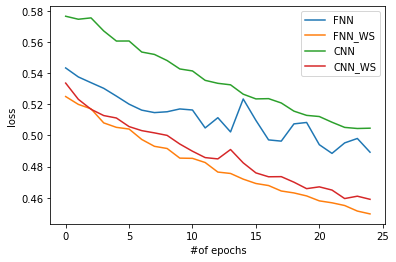

In [47]:
curve_names = [x['model'].__class__.__name__ for x in models]
plotLoss(histories[:2] + [histories[4]] + [histories[6]], '#of epochs', 'loss', curve_names[:2] + [curve_names[4]] + [curve_names[6]])

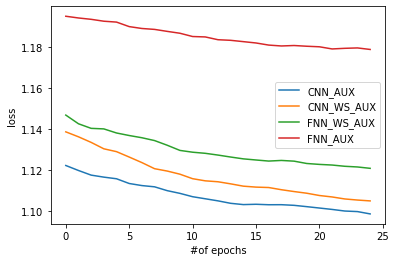

In [56]:
plotLoss([histories[7]] + [histories[5]] + histories[2:4], '#of epochs', 'loss',  [curve_names[7]] + [curve_names[5]] + curve_names[2:4])